In [1]:
import numpy as np
import pandas as pd 
import glob
import json
import os

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
path = "/Users/adityavs14/Documents/Internship/Pianalytix/Month_2/COVIDCluster/ML_model/metadata.csv"

In [3]:
meta_df = pd.read_csv(path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})

/var/folders/gx/cgwnkj8172lfc4nmcl9j2fqr0000gn/T/ipykernel_3679/779213733.py:1: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(path, dtype={


In [4]:
dict_ = {'paper_id': meta_df['sha'] , 'doi':meta_df.doi, 'title':meta_df.title,'abstract':meta_df.abstract,'authors':meta_df.authors,'journal':meta_df.journal}

In [5]:
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi','title','abstract', 'authors', 'journal', 'abstract_summary'])

In [6]:
df_covid.fillna(value='', inplace=True)
df = df_covid.sample(5000, random_state=40)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [ ]:
text = df['abstract'].values
max_features = 2**10

X1 = vectorize(text, max_features)

In [ ]:
text = df['journal'].values
max_features = 2**4

X2 = vectorize(text, max_features)

In [8]:
text = df['title'].values+df['journal'].values
max_features = 2**5

X3 = vectorize(text, max_features)

In [9]:
X = X3

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=40)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape
#X_reduced = X

(5000, 27)

In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans


In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist
from tqdm import tqdm

# run kmeans with many different k
distortions = []
K = range(10, 30)
for k in tqdm(K):
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [12]:
k = 25
kmeans = KMeans(n_clusters=k, random_state=40)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1,init='pca', perplexity=50)
X_embedded = tsne.fit_transform(X.toarray())

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.632s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.866272
[t-SNE] KL divergence after 1000 iterations: 1.213516


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


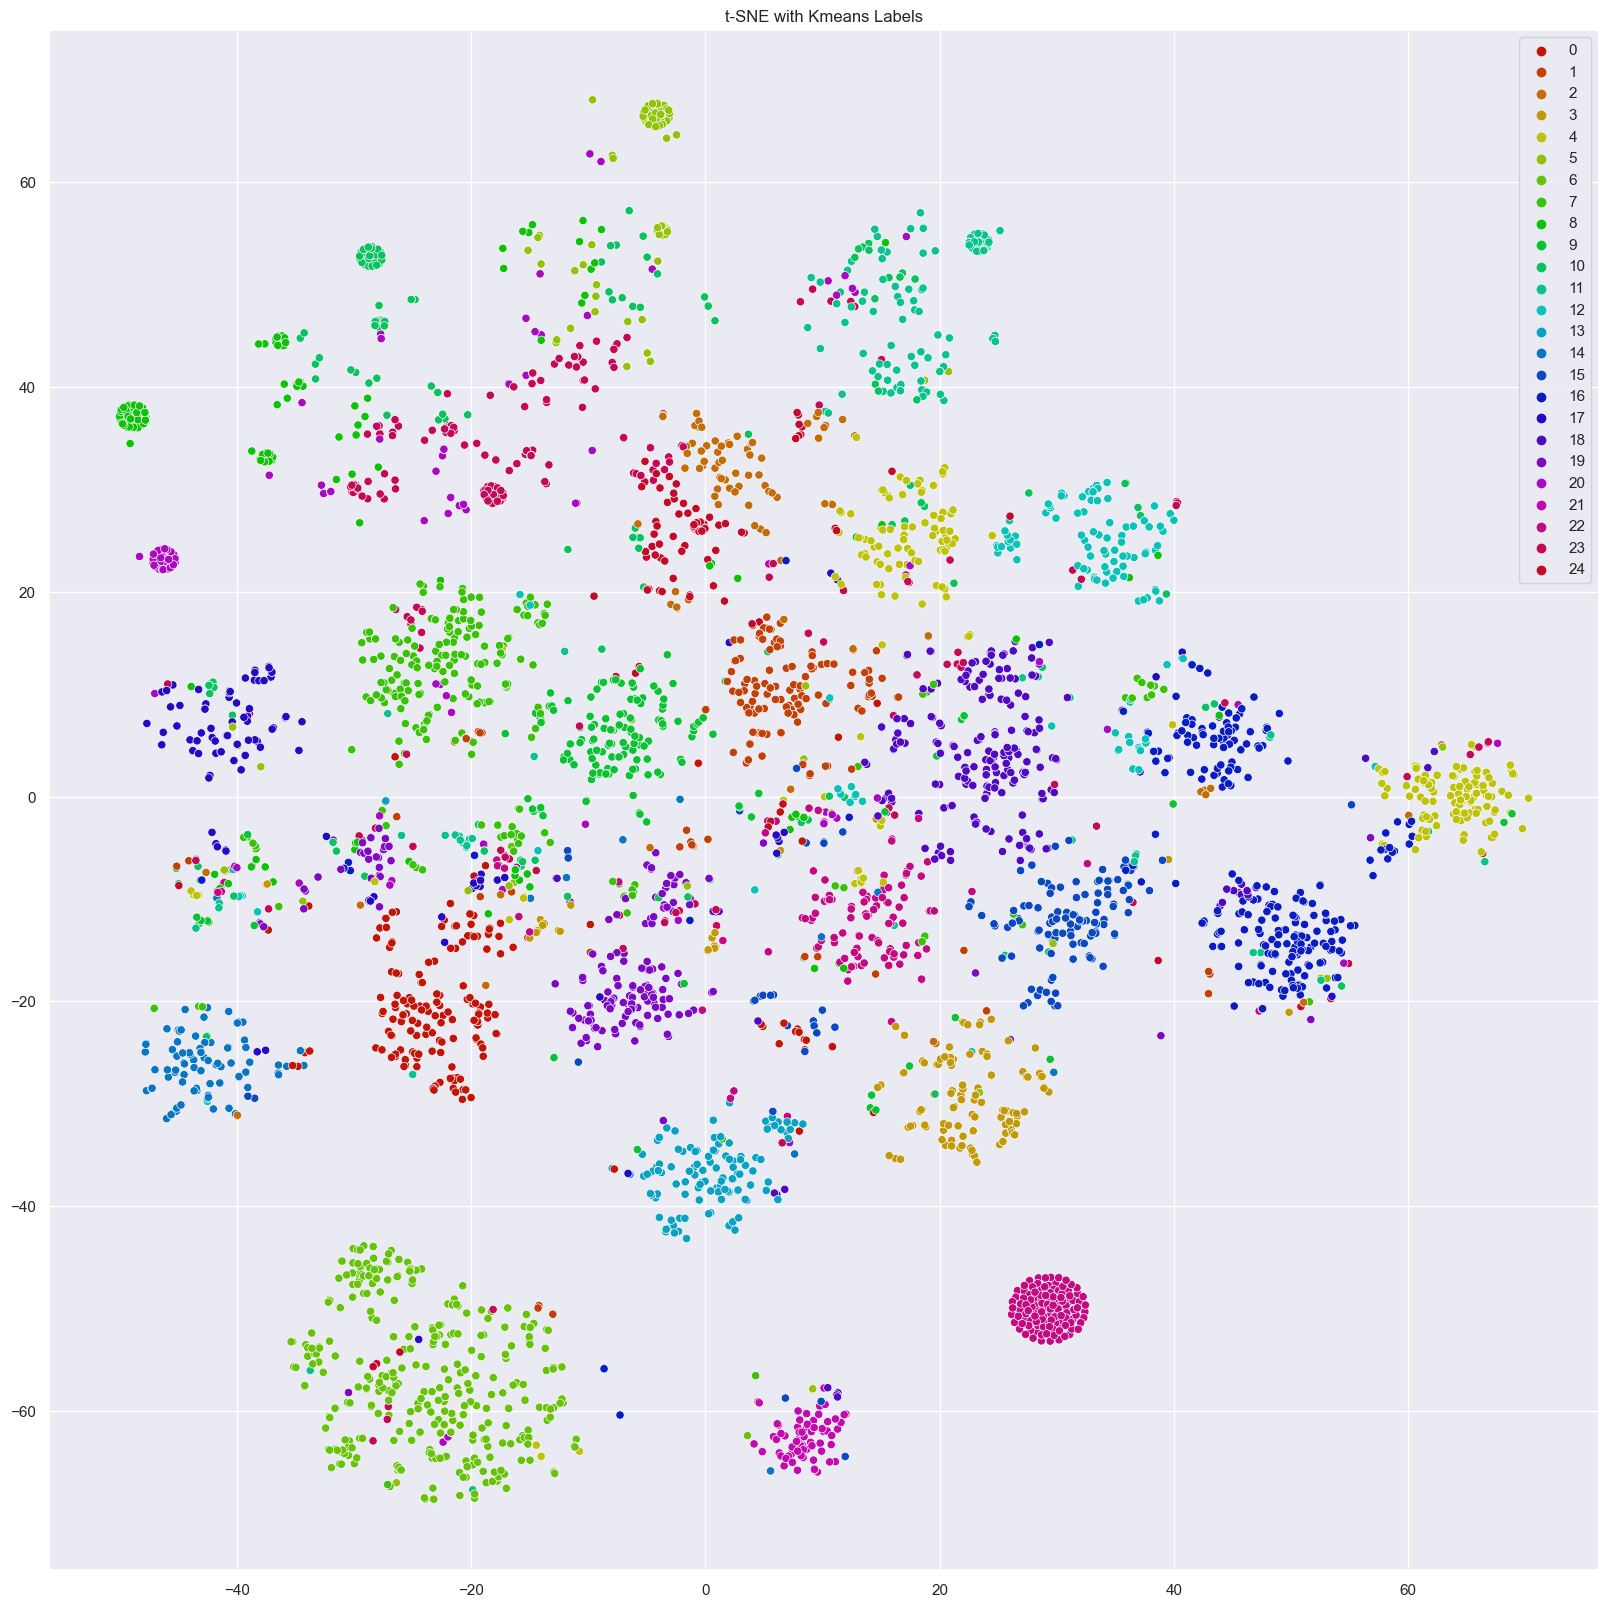

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(20,20)})

# colors
palette = sns.hls_palette(25, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
#plt.savefig("improved_cluster_tsne.png")
plt.show()